<h2> Importing Important Packages 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

<h2>Importing Dataset that already preprocessed

In [25]:
path_to_file = 'data/padi.csv'
province = 'DI YOGYAKARTA'
sliding_window = 3
train_test_proportion = 0.8

from preprocessing import preprocess

data = pd.read_csv(path_to_file)
preprocessed = preprocess(data[data['Provinsi'] == province],\
                            sliding_window)

preprocessed.head()

,0,1,2,3
0,644642,643266,642120,661179
1,643266,642120,661179,647198
2,642120,661179,647198,621605
3,661179,647198,621605,612393
4,647198,621605,612393,654289


<h2> Split Dataset into 2 gourp (train and test test)

In [26]:
train_data = preprocessed[:int(train_test_proportion*preprocessed.shape[0])]
test_data = preprocessed.drop(train_data.index)

train_labels = train_data.pop(train_data.columns[-1])
test_labels = test_data.pop(test_data.columns[-1])

<h2> make Modeling function

In [27]:
def build_model():
    model = keras.Sequential([
        layers.Dense(2, activation=tf.nn.relu,
                     input_shape=[len(train_data.keys())]),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='mae', optimizer='adam', metrics=['mse'])

    return model

In [28]:
tf.random.set_seed(28)

model = build_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


<h2> Make chackpoint to save model weights

In [29]:
checkpoint_path = "model/cp_weights_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,period=10,
                                                 verbose=1)

model.save_weights(checkpoint_path.format(epoch=0))

<h2> Train Regression model 

In [30]:
epochs = 100
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

history = model.fit(train_data, train_labels, epochs=epochs, validation_split=0.2, verbose=1, callbacks=[early_stop])

model.save('model')

Train on 12 samples, validate on 4 samples
Epoch 1/100
12/12 [==============================] - 0s 34ms/sample - loss: 529078.0000 - mse: 280613322752.0000 - val_loss: 666411.0625 - val_mse: 444179873792.0000
Epoch 2/100
12/12 [==============================] - 0s 917us/sample - loss: 524167.2500 - mse: 275437715456.0000 - val_loss: 660763.8750 - val_mse: 436681146368.0000
Epoch 3/100
12/12 [==============================] - 0s 916us/sample - loss: 519237.8438 - mse: 270290862080.0000 - val_loss: 655094.5000 - val_mse: 429217251328.0000
Epoch 4/100
12/12 [==============================] - 0s 917us/sample - loss: 514289.2500 - mse: 265173024768.0000 - val_loss: 649402.5000 - val_mse: 421788516352.0000
Epoch 5/100
12/12 [==============================] - 0s 833us/sample - loss: 509321.3750 - mse: 260084482048.0000 - val_loss: 643687.5000 - val_mse: 414395334656.0000
Epoch 6/100
12/12 [==============================] - 0s 1ms/sample - loss: 504333.7500 - mse: 255025430528.0000 - val_loss:

<h2> Plotting Training Process

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

#Show last Epoch matrics result
hist.tail()

,loss,mse,val_loss,val_mse,epoch
95,26333.421875,1.091911e+09,41219.328125,2.399677e+09,95
96,26047.250000,1.071067e+09,41737.015625,2.479241e+09,96
97,25399.218750,1.025241e+09,42514.250000,2.603523e+09,97
98,24425.822266,9.600061e+08,43524.437500,2.773702e+09,98
99,23160.349609,8.816712e+08,44743.578125,2.992070e+09,99


In [32]:
def ploting_history(history):

    plt.figure(figsize=(14,8))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error (Target)')
    plt.title('Mean Absolute Error values change')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    plt.legend()
    # plt.ylim([0, 5])
    plt.savefig('plot/ABS train history.pdf') 

    plt.figure(figsize=(14,8))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error (Target^2)')
    plt.title('Mean Square Error values change')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.legend()
    # plt.ylim([0, 20])
    plt.savefig('plot/MAE train history.pdf')  

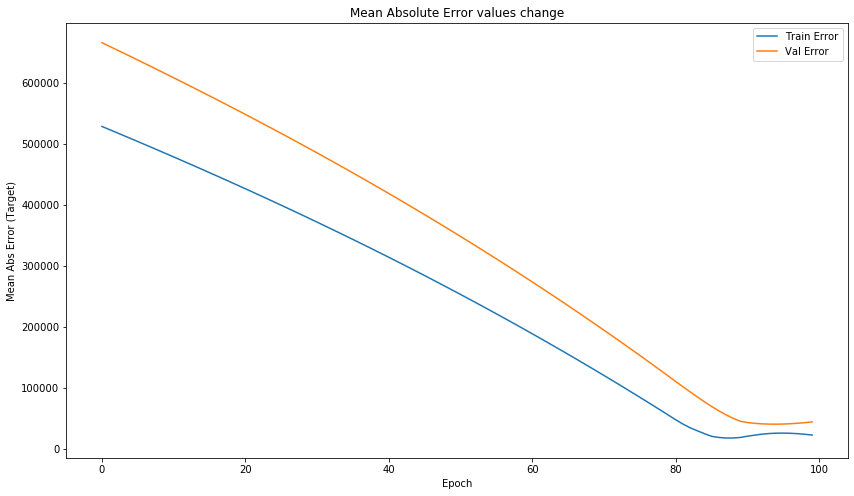

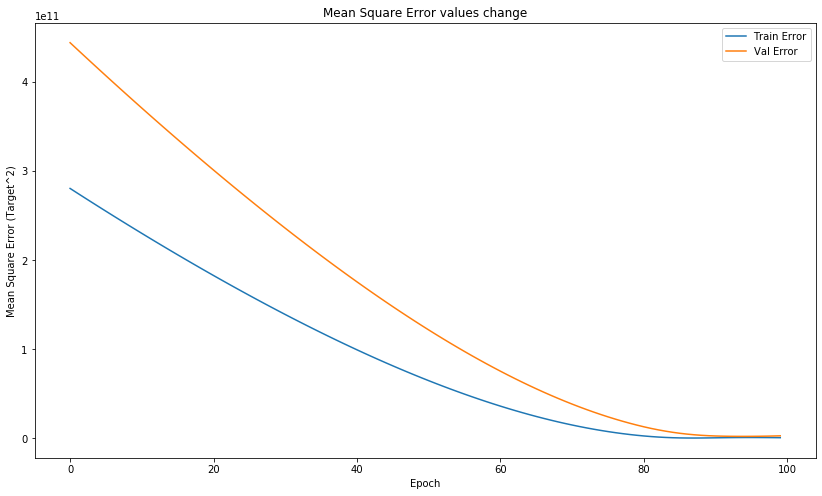

In [33]:
ploting_history(history)

<h2> Checking Evaluation metrics model

In [34]:
model.evaluate(test_data, test_labels, verbose=0)
#     print("Test Set Mean Abs Error : {:5.2f} Commodity in ton".format(mae))

[30390.125, 1568806900.0]

<h2> Predicting Test data

In [35]:
prediction = model.predict(test_data).flatten()

result_comparison = pd.DataFrame(list(zip(test_data.values.tolist(),prediction, test_labels.tolist())), 
               columns =['Features','Prediction','Actual'])

result_comparison['error'] = (abs(result_comparison['Actual'] - result_comparison['Prediction'])/
                               result_comparison['Prediction'])
result_comparison

,Features,Prediction,Actual,error
0,"[837930, 823887, 842934]",874431.4375,946224,0.082102
1,"[823887, 842934, 946224]",906722.0625,921824,0.016656
2,"[842934, 946224, 921824]",914325.5625,919573,0.005739
3,"[946224, 921824, 919573]",974554.5625,945136,0.030187


In [36]:
print(result_comparison.error.mean())

0.033670833236638456


In [37]:
loss, mse = model.evaluate(test_data, test_labels, verbose=0)
print("Mean Absolute Error : {:5.2f} Commodity in ton".format(loss))
print("Mean Squared Error : {:5.2f} Commodity in ton".format(mse))
print(result_comparison.error.mean())

Mean Absolute Error : 30390.12 Commodity in ton
Mean Squared Error : 1568806912.00 Commodity in ton
0.033670833236638456


<h2> Ploting data distribution and prediction

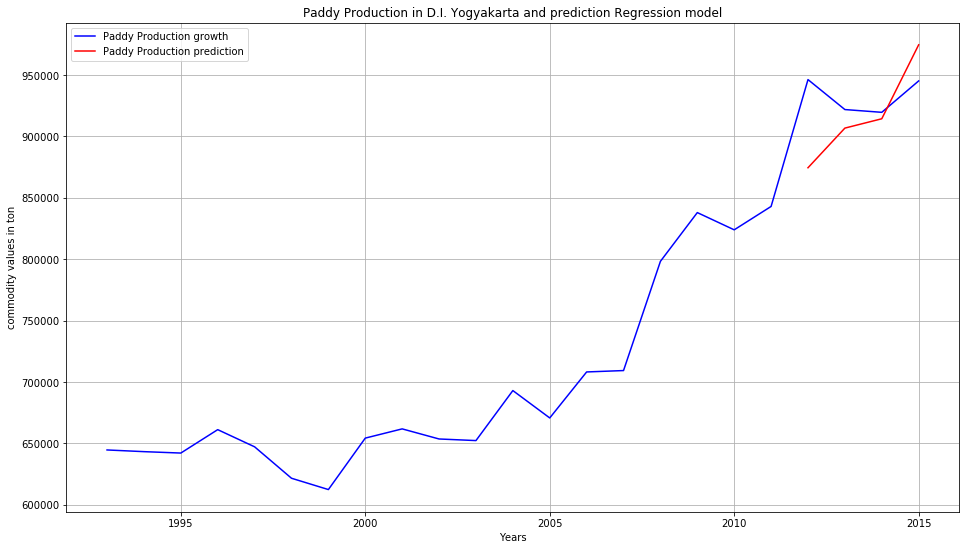

In [38]:
data_paddy = pd.read_csv('data/padi.csv')
data_paddy_central_java = data_paddy[data_paddy['Provinsi']=="DI YOGYAKARTA"]
data_paddy_central_java = data_paddy_central_java.drop(columns='Provinsi')
data_paddy_central_java = data_paddy_central_java.T
data_paddy_central_java = data_paddy_central_java.reset_index()
data_paddy_central_java = data_paddy_central_java.rename(columns={"index":"Years",13:"Commodition_in_Ton"})
data_paddy_central_java = data_paddy_central_java[['Years', 'Commodition_in_Ton']].apply(pd.to_numeric)

pred = data_paddy_central_java.rename(columns={"Commodition_in_Ton":'predict'}).iloc[-len(test_data):, :]
pred['predict'] = [round(num, 1) for num in prediction]
fig = plt.figure(figsize=(16,9))
plt.grid()
plt.xlabel('Years')
plt.ylabel('commodity values in ton')
plt.title('Paddy Production in D.I. Yogyakarta and prediction Regression model')
plt.plot(data_paddy_central_java['Years'], 
         data_paddy_central_java['Commodition_in_Ton'], 
#          kind='scatter',
         'b-',label='Paddy Production growth')

plt.plot(pred['Years'], 
         pred['predict'], 
#          kind='scatter',
         'r-',label='Paddy Production prediction')

plt.legend()
plt.savefig('plot/Paddy Production growth vs prediction.pdf') 
plt.show()

<h2> Predicting paddy production for 2016

In [39]:
data_prediction = np.array([921824,919573,945136])
data_prediction = data_prediction[None, :]

predict_2016 = model.predict(data_prediction).flatten()
print("Paddy Production for Year 2016 : {} Commodity in ton".format(int(predict_2016)))

Paddy Production for Year 2016 : 969536 Commodity in ton
